In [1]:
# import ml packages

import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import (CountVectorizer, HashingVectorizer, TfidfVectorizer)
from imblearn.over_sampling import SMOTE

# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, TruncatedSVD


In [2]:
# import dataset
train_df = pd.read_csv("../AskReddit Dataset/AskReddit Dataset/train.csv")
test_df = pd.read_csv("../AskReddit Dataset/AskReddit Dataset/test.csv")
train_df.head()

,qid,question_text,target
0,a3dee568776c08512c89,What is the role of Lua in Civ4?,0
1,bdb84f519e7b46e7b7bb,What are important chapters in Kannada for 10 ...,0
2,29c88db470e2eb5c97ad,Do musicians get royalties from YouTube?,0
3,3387d99bf2c3227ae8f1,What is the difference between Scaling Social ...,0
4,e79fa5038f765d0f2e7e,Why do elevators go super slow right before th...,0


In [3]:
# choose elements from df where target = 1
pd.set_option("display.max_colwidth", 100)
df_1 = train_df[train_df["target"] == 1]
df_1["question_text"]

16                                                     What stupid things do Indians do when in your country?
31                             Can I sue my parents for giving birth to me when I did not want them to do so?
32                          What are your views about sexual relationship between a widow mother and her son?
33        You became an atheist, and after 2 years you fall and break your back. You are left paralyzed fr...
90                                    Why aren't we protesting for government control instead of gun control?
                                                         ...                                                 
652967              What is a liberal's understanding of the difference between pollution and climate change?
653021    Do unattractive or average-looking men ever get a girlfriend who actually loves them or do they ...
653029                                                                   How can I grab my aunties boobs! :p?
653034    

In [4]:
# see value count order of target
train_df["target"].value_counts()

0    612656
1     40405
Name: target, dtype: int64

In [5]:
# percentage of troll questions in the dataset
train_df["target"].value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

# EDA

<AxesSubplot:xlabel='target', ylabel='count'>

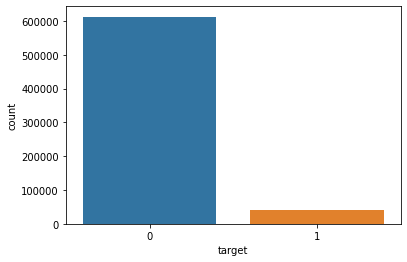

In [6]:
# graphing label counts
sns.countplot(x="target", data=train_df)

<AxesSubplot:xlabel='target'>

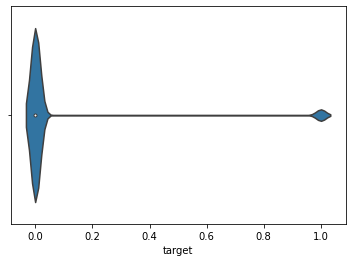

In [7]:
# violin plot of label value counts
sns.violinplot(x="target", data=train_df, hue="target")

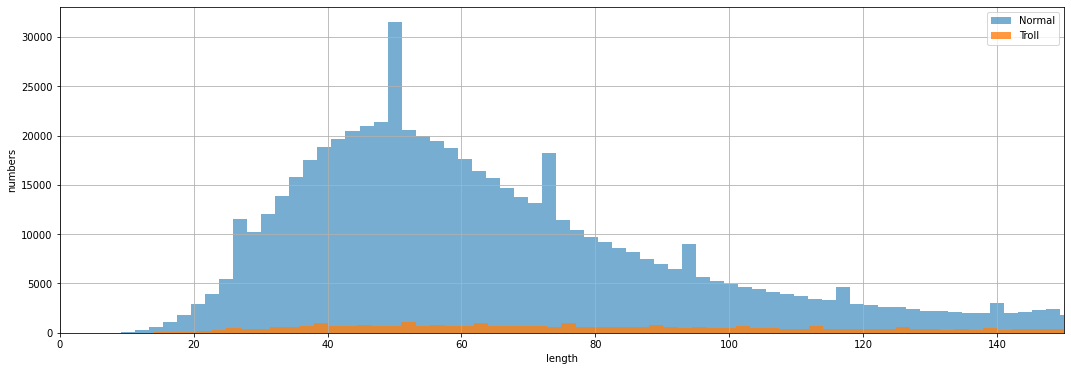

In [8]:
# plot the number of charecters in train_df
train_df['length'] = train_df['question_text'].apply(lambda x: len(x))

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train_df[train_df['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Normal')
plt.hist(train_df[train_df['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Troll')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

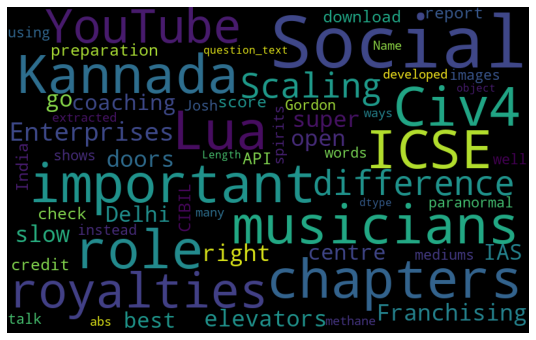

In [9]:
from wordcloud import WordCloud
# create a word cloud using train_Df
word_cloud = WordCloud(width=800, height=500, random_state=25, max_font_size=110).generate(str(train_df['question_text']))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

# Preprocessing

In [10]:
# create a preprocessing class
class Preprocessor:
    def __init__(self, df) -> None:
        self.df = df

    # convert all charecters to lower case
    def convertToLower(self):
        self.df["question_text"] = self.df["question_text"].apply(lambda x: x.lower())
        return self.df

    # remove stop words
    def removeStopWords(self):
        stop = stopwords.words("english")
        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: " ".join([word for word in x.split() if word not in stop])
        )
        return self.df

    # remove punctuation
    def removePunctuation(self):
        self.df["question_text"] = self.df["question_text"].str.replace("[^\w\s]", "")
        return self.df

    # remove numbers
    def removeNumbers(self):
        self.df["question_text"] = self.df["question_text"].str.replace("[0-9]", "")
        return self.df

    # remove whitespaces
    def removeWhitespaces(self):
        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: " ".join(x.split())
        )
        return self.df

    # remove urls
    def removeURLs(self):
        self.df["question_text"] = self.df["question_text"].str.replace(
            "https?://\S+|www\.\S+", ""
        )
        return self.df

    # snowball stemmer algorithm
    def snowballstemmer(self):
        stemmer = SnowballStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    # port stemmer algorithm
    def porterstemmer(self):
        stemmer = PorterStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    # lemmatizing
    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer

        lemmatizer = WordNetLemmatizer()

        def lemmatize_words(text):
            return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: lemmatize_words(x)
        )
        return self.df

    # remove id and index columns
    def removeUnwantedCols(self, col):
        print(self.df.shape)
        self.df = self.df.drop(col, axis=1)
        return self.df

    # word tokenization using nltk
    def wordTokenization(self):
        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: nltk.word_tokenize(x)
        )
        return self.df
        

    def preprocess(self):
        # self.df = self.convertToLower()
        # self.df = self.removeStopWords()
        # self.df = self.removePunctuation()
        # self.df = self.removeNumbers()
        # self.df = self.removeURLs()
        # self.df = self.removeWhitespaces()
        # self.df = self.snowballstemmer()
        # self.df = self.porterstemmer()
        # self.df = self.lemmatize()
        # self.df = self.wordTokenization()
        self.df = self.removeUnwantedCols(["qid"])
        # print(self.df.head())
        return self.df

In [11]:
preproccesor = Preprocessor(train_df)
preprocessed_df = preproccesor.preprocess()
preprocessed_df.head()

(653061, 4)


,question_text,target,length
0,What is the role of Lua in Civ4?,0,32
1,What are important chapters in Kannada for 10 ICSE 2018?,0,56
2,Do musicians get royalties from YouTube?,0,40
3,What is the difference between Scaling Social Enterprises and Social Franchising?,0,81
4,Why do elevators go super slow right before the doors open?,0,59


In [12]:
# get shape of preprocessed_df
preprocessed_df.shape

(653061, 3)

In [50]:
# create a get train and test data class
from nltk.tokenize import RegexpTokenizer

class TrainTestData:
    def __init__(self, trainDf, testDf) -> None:
        self.trainDf = trainDf
        self.testDf = testDf

    def doSmote(self):
        sm = SMOTE()
        self.X, self.Y = sm.fit_resample(self.X, self.Y)
        return self.trainData, self.testData

    def doDecomposition(self):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(self.X)
        self.trainData = lsa.transform(self.X)
        self.testData = lsa.transform(self.testData)
        

    def get_X(self, minDocumentCount):

        # concatinate trainDf and testDf
        self.resampling()
        self.appendDf = pd.concat(
            [self.trainDf["question_text"], self.testDf["question_text"]], axis=0
        )

        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        vectorizer = CountVectorizer()
        #vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,3),tokenizer=token.tokenize)
        # lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize
        vectorizer.fit(self.appendDf)

        self.trainData = vectorizer.transform(self.trainDf["question_text"])
        print(self.trainData.shape)

        self.testData = vectorizer.transform(self.testDf["question_text"])
        print(self.testData.shape)
        self.X = self.trainData

        # self.doDecomposition() 
        return self.X

    def resampling(self):
        from sklearn.utils import resample
        zero_data = self.trainDf[self.trainDf['target'] == 0]
        one_data = self.trainDf[self.trainDf['target'] == 1]
        self.trainDf = pd.concat([resample(zero_data, replace=True, n_samples=len(one_data)*6), one_data])
        return self.trainDf

    def get_Y(self):
        # self.resampling()
        self.Y = self.trainDf["target"]
        return self.Y

    def testTrainSplit(self):
        # self.doSmote()
        (
            self.X_train,
            self.X_test,
            self.Y_train,
            self.Y_test,
        ) = model_selection.train_test_split(
            self.X, self.Y, test_size=0.2, random_state=0
        )
        return self.X_train, self.X_test, self.Y_train, self.Y_test

    def get_X_test(self):
        return self.testData

In [51]:
testPreprocessor = Preprocessor(test_df)
preprocessed_test_df = testPreprocessor.preprocess()
preprocessed_test_df.head()

getTTData = TrainTestData(preprocessed_df, preprocessed_test_df)
X = getTTData.get_X(1)
y = getTTData.get_Y()
X_train, X_test, Y_train, Y_test = getTTData.testTrainSplit()

(653061, 2)
(282835, 159014)
(653061, 159014)


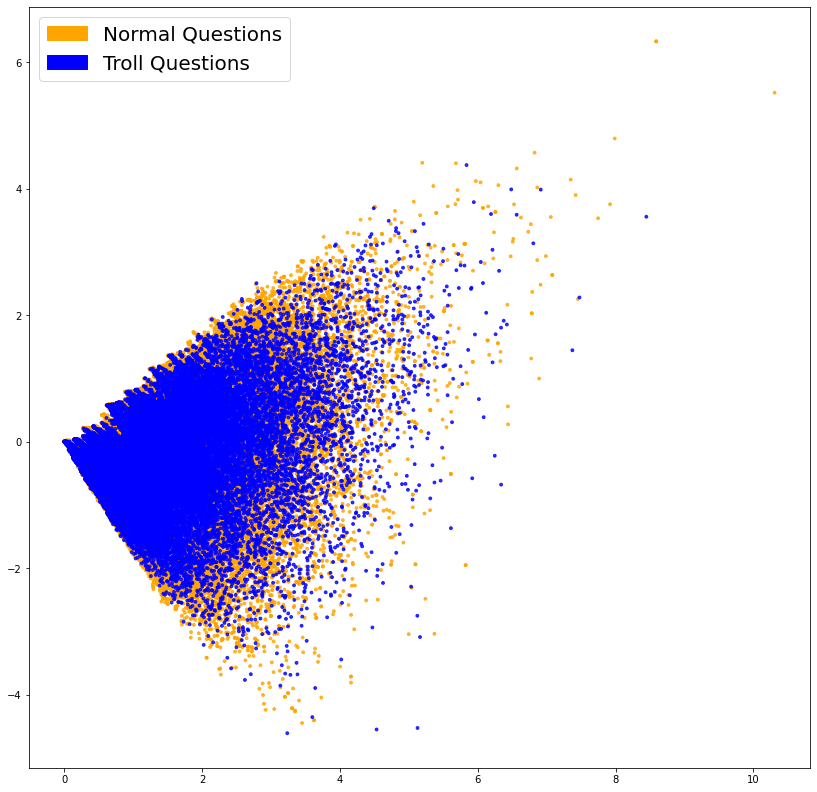

In [52]:
# visualising the embeddings
from matplotlib import patches as mpatches
import matplotlib 

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels,cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Normal Questions')
            blue_patch = mpatches.Patch(color='blue', label='Troll Questions')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

fig = plt.figure(figsize=(14, 14))          
plot_LSA(X, y)
plt.show()

# Binary Classification using logistic regression

In [53]:
C_vals = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5]
from sklearn.metrics import fbeta_score
accuracy_arr = []

for c in C_vals:
    lrModel = LogisticRegression(C=c,solver="liblinear",class_weight={1:4})
    lrModel.fit(X_train, Y_train)
    y_actual = Y_test
    cv_preds = lrModel.predict(X_test)
    accuracy_arr.append(fbeta_score(y_actual, cv_preds, average="macro", beta=0.5))

print(accuracy_arr)

# plot accuracy vs C
plt.plot(C_vals, accuracy_arr)

KeyboardInterrupt: 

In [61]:
lrModel = LogisticRegression(C=0.70,solver="liblinear")
lrModel.fit(X_train, Y_train)

LogisticRegression(C=0.7, solver='liblinear')

In [62]:
y_actual = Y_test
cv_preds = lrModel.predict(X_test)
print(cv_preds.shape)
from sklearn.metrics import fbeta_score

fbeta_score(y_actual, cv_preds, average="macro", beta=0.5)

(56567,)


0.8532614885114322

Text(0.5, 33.0, 'Predicted label')

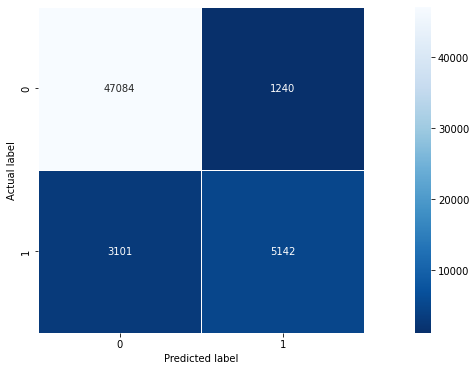

In [63]:
# use sns to plot the confusion matrix
cm = confusion_matrix(y_actual, cv_preds)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# Linear SVM Classification

In [19]:
# linear svm classification
model = LinearSVC(C=0.18,class_weight={0:1,1: 4})
model.fit(X_train, Y_train)

LinearSVC(C=0.18, class_weight={0: 1, 1: 4})

In [20]:
y_actual = Y_test
cv_preds = model.predict(X_test)

from sklearn.metrics import fbeta_score

fbeta_score(y_actual, cv_preds, average="macro", beta=0.5)

0.7936467945735661

# Logistic Regression with cross validation

In [56]:
from sklearn.linear_model import LogisticRegressionCV
lrCvModel = LogisticRegressionCV(cv=5, solver='liblinear', class_weight={0:1,1: 4})
lrCvModel.fit(X_train, Y_train)

C:\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
# from sklearn.linear_model import SGDClassifier
# sgdModel = SGDClassifier(loss='log', penalty='l1', alpha=0.0001, max_iter=1000, tol=None)
# sgdModel.fit(X_train, Y_train)

# Binary classification using Multinomial NB

In [23]:
# from sklearn.naive_bayes import MultinomialNB
# mulNbClf = MultinomialNB().fit(X_train,Y_train)
# mulNbPreds = mulNbClf.predict(X_test)
# fbeta_score(Y_test, mulNbPreds, average='macro', beta=0.5)
# np.unique(mulNbPreds, return_counts=True)

# XGBoost Classifier

In [24]:
# fit model no training data
# xgbModel = XGBClassifier()
# xgbModel.fit(X_train, Y_train)
# xgbModel.predict(X_test)

# Grid Search CV

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# do gridsearchCV 
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
gridSearchClf = GridSearchCV(svc, parameters)
gridSearchClf.fit(X_train, Y_train)

# Creating a csv out of the test data for submission

In [29]:
preprocessed_test_df.shape
preprocessed_test_df.head()

,question_text
0,Why is my fish tank so cloudy?
1,Are AAP supporters/leaders hypocrites?
2,Can you still get a ticket if you shut off your car before a cop flips his lights?
3,Why should any liberal or caring person want to stay in this country after nine months of Trump?
4,How can I know who got into my PC using anydesk?


In [64]:
# create a class submission pipeline
class SubmissionPipeline:
    def __init__(self, testDf, model,testTrainData, submissionIndex):
        self.testDf = testDf
        self.model = model
        self.getTTData = testTrainData
        self.submissionIndex = submissionIndex

    def run(self):
        self.predictions = self.model.predict(getTTData.get_X_test())
        print("Unique counts in predictions: {}".format(np.unique(self.predictions, return_counts=True)))
        self.submission_df = pd.DataFrame({"qid": self.testDf["qid"], "target": self.predictions})
        print("Value counts in submission df:\n{}".format(self.submission_df["target"].value_counts()))
        self.submission_df.to_csv("admiral_general_aladdin_submission{}.csv".format(self.submissionIndex), index=False)
        print("Submission file saved!")
        

In [65]:
submissionPipeline = SubmissionPipeline(test_df, lrModel, getTTData, 112)
submissionPipeline.run()

Unique counts in predictions: (array([0, 1], dtype=int64), array([609902,  43159], dtype=int64))
Value counts in submission df:
0    609902
1     43159
Name: target, dtype: int64
Submission file saved!
